In [34]:
!pip install pandas nltk matplotlib scikit-learn seaborn lime shap

In [35]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import shap
from shap.maskers import Independent
import scipy.sparse

In [36]:
# Ensure NLTK resources are downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [37]:
# Step 1: Load the dataset
def load_data(file_path):
    data = pd.read_csv(file_path, low_memory = False)
    print(f"Data shape: {data.shape}")
    print(f"Data columns: {data.columns}")

    data = data.iloc[:, [1, 3]]
    data.columns = ['text', 'label']
    data['label'] = data['label'].map({0: "No Issues", 1: "Mental Health Issues"})
    data = data[['text', 'label']]
    data = data.dropna(subset=['label'])
    print("First few rows of the data:")
    print(data.head())
    return data

In [38]:
# Step 2: Data Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@\w+|#\w+|http\S+|www\S+|[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [39]:
# Step 3: Prepare the data for modeling
def prepare_data(data):
    data['text'] = data['text'].apply(preprocess_text)
    x = data['text']
    y = data['label']
    print(f"x type:{type(x)}")
    print(f"y type:{type(y)}")
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    cv = TfidfVectorizer()
    X = cv.fit_transform(x)
    print(f"X shape: {X.shape}")
    return X, y, cv

In [40]:
# Step 4: Predict mental health status using the best model
def predict_mental_health(model, cv, text):
    processed_text = preprocess_text(text)
    text_vector = cv.transform([processed_text])
    prediction = model.predict(text_vector)
    return prediction[0]

In [41]:
# Step 5: Train the models and evaluate
def evaluate_models(X, y, model, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    model.predict_proba(X_train)

    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f'Train Accuracy: {train_accuracy:.2f}')
    print(f'Test Accuracy: {test_accuracy:.2f}')


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label="Mental Health Issues")
    recall = recall_score(y_test, y_pred, pos_label="Mental Health Issues")
    f1 = f1_score(y_test, y_pred, pos_label="Mental Health Issues")
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label="Mental Health Issues")
    roc_auc = auc(fpr, tpr)

    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "conf_matrix": conf_matrix,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "model": model  # Added model instance
    }

In [42]:
# Step 6: Function to plot and save combined comparison graph
def plot_combined_comparison_graph(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    model_names = list(results.keys())
    scores = {metric: [results[model_name][metric] for model_name in model_names] for metric in metrics}

    x = np.arange(len(model_names))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, scores[metric], width, label=metric_names[i])

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Model_Performance_Comparison.png')
    plt.show()

# Step 7: Function to plot and save separate confusion matrices
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Issues", "Mental Health Issues"], yticklabels=["No Issues", "Mental Health Issues"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

# Step 8: Function to plot and save combined ROC curves
def plot_combined_roc_curves(results, model_names):
    plt.figure(figsize=(8, 6))

    for model_name, result in results.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="upper left")
    plt.savefig('ROC_curve_comparison.png')
    plt.show()

In [43]:
# Model Explanation
def explain_models(results, X_reduced, y, cv): # Changed X to X_reduced
    best_model_name = max(results, key=lambda name: results[name]['accuracy'])
    model = results[best_model_name]['model']

    # Split the reduced-dimensionality data
    X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

    # Use a smaller subset of the reduced training data for explanation
    subset_size = 20 # Reduced subset size
    # The reduced data from TruncatedSVD is already dense, so no need for .toarray()
    subset = X_train_reduced[:subset_size]

    # Use KernelExplainer
    # KernelExplainer works with dense data, which the reduced data is
    explainer = shap.Explainer(model.predict_proba, subset) # Use predict_proba for classification explanations

    # Get SHAP values for a subset of the test data
    # Use the reduced test data
    shap_values = explainer.shap_values(X_test_reduced[:subset_size], check_additivity=False) # Calculate SHAP for a subset of test data

    shap.initjs()

    # Plot SHAP summary plot
    # Since the features are now SVD components, use generic feature names or omit them.
    # Passing the reduced test data for plotting
    shap.summary_plot(shap_values[1], X_test_reduced[:subset_size], feature_names=[f'Component {i+1}' for i in range(X_reduced.shape[1])], max_display=20) # Assuming index 1 is 'Mental Health Issues' class and using component names
    plt.title(f'{best_model_name} SHAP Summary Plot for "Mental Health Issues" Class (Top 20 Features)')
    # Save the plot to a file
    plot_filename = f'{best_model_name}_SHAP_summary_top20_reduced.png' # Changed filename
    plt.savefig(plot_filename, dpi=900, bbox_inches = "tight")

    # Close the plot to prevent it from displaying twice
    plt.close()

    # Display the saved image
    from IPython.display import Image
    display(Image(filename=plot_filename))

Data shape: (55518, 4)
Data columns: Index(['subreddit', 'text', 'id', 'label'], dtype='object')
First few rows of the data:
                                                text                 label
0  He said he had not felt that way before, sugge...  Mental Health Issues
1  Hey there r/assistance, Not sure if this is th...             No Issues
2  My mom then hit me with the newspaper and it s...  Mental Health Issues
3  until i met my new boyfriend, he is amazing, h...  Mental Health Issues
4  October is Domestic Violence Awareness Month a...  Mental Health Issues
x type:<class 'pandas.core.series.Series'>
y type:<class 'pandas.core.series.Series'>
x shape: (55518,)
y shape: (55518,)
X shape: (55518, 72656)
Train Accuracy: 0.80
Test Accuracy: 0.77
MultinomialNB - Accuracy: 0.77, Precision: 0.75, Recall: 0.99, F1 Score: 0.85
Train Accuracy: 0.95
Test Accuracy: 0.93
LogisticRegression - Accuracy: 0.93, Precision: 0.95, Recall: 0.95, F1 Score: 0.95
Train Accuracy: 0.89
Test Accuracy: 

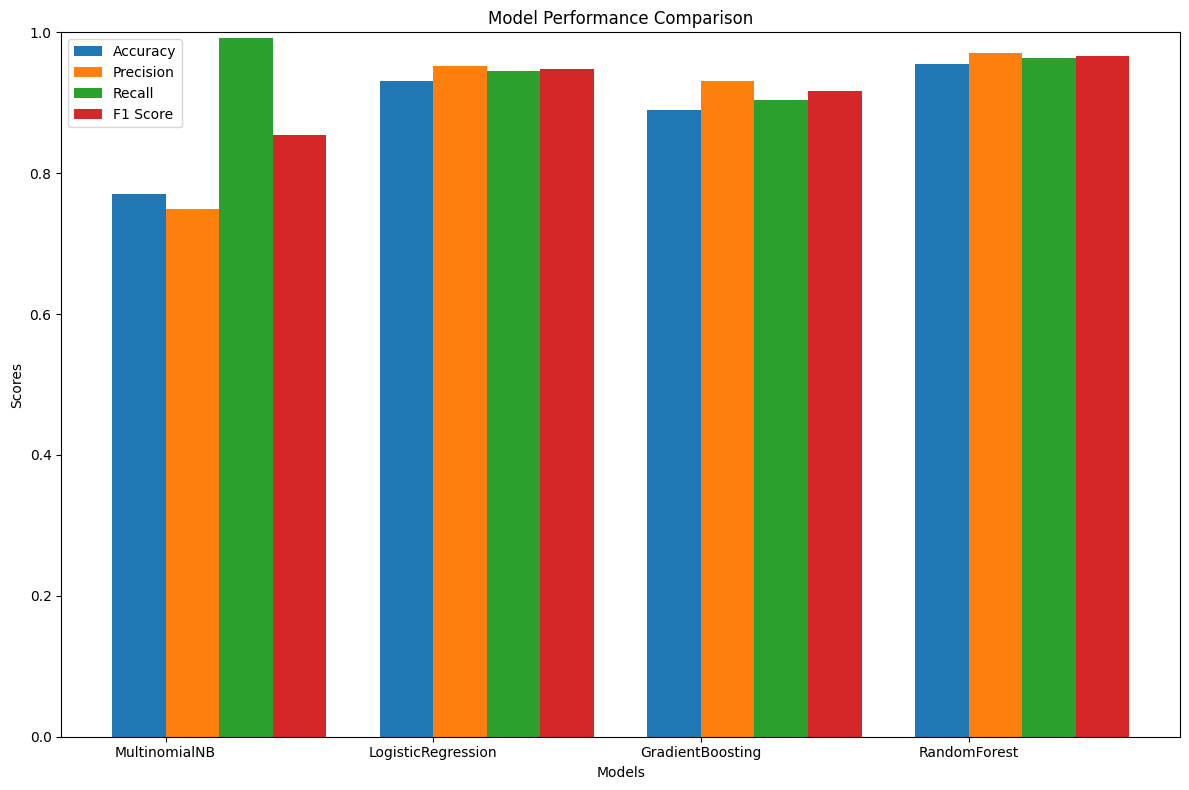

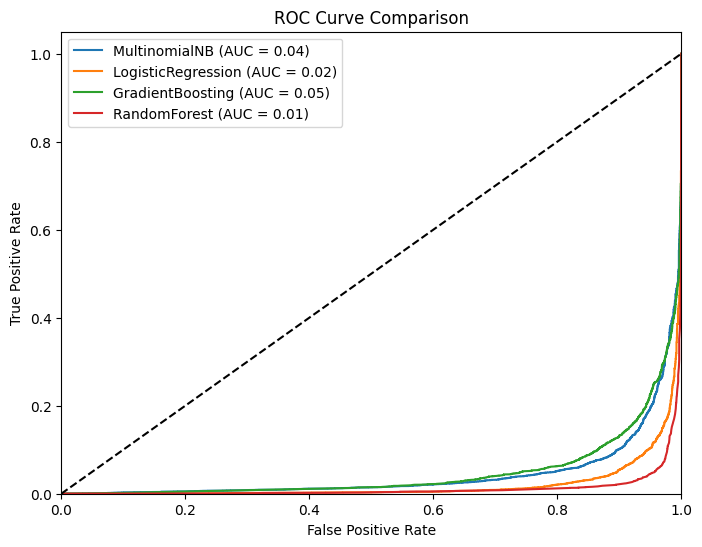

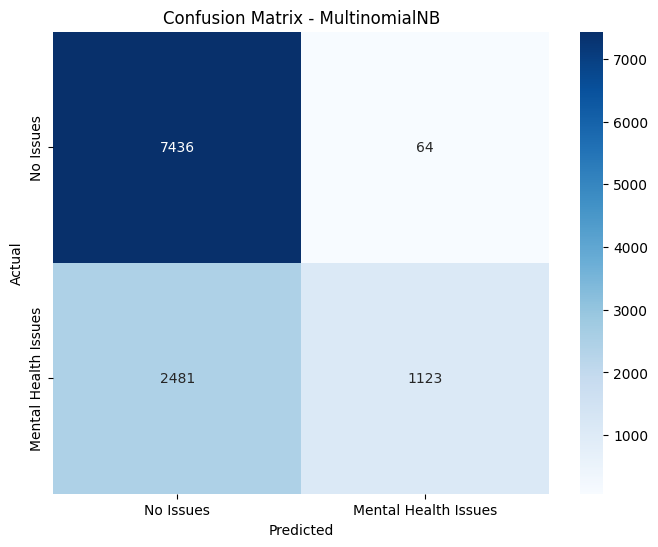

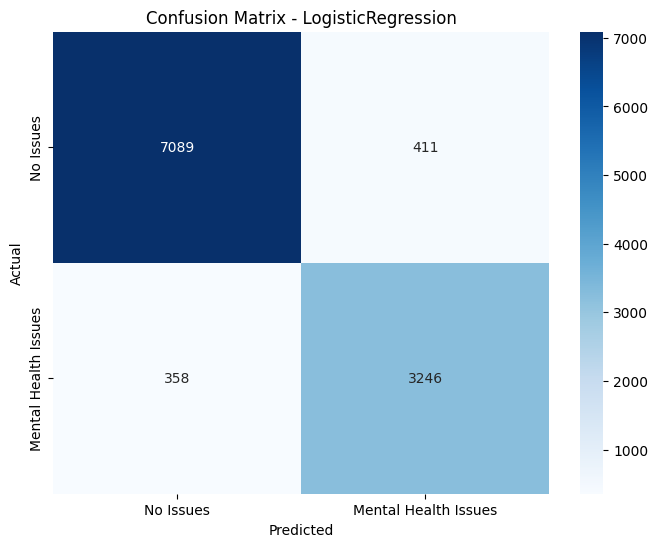

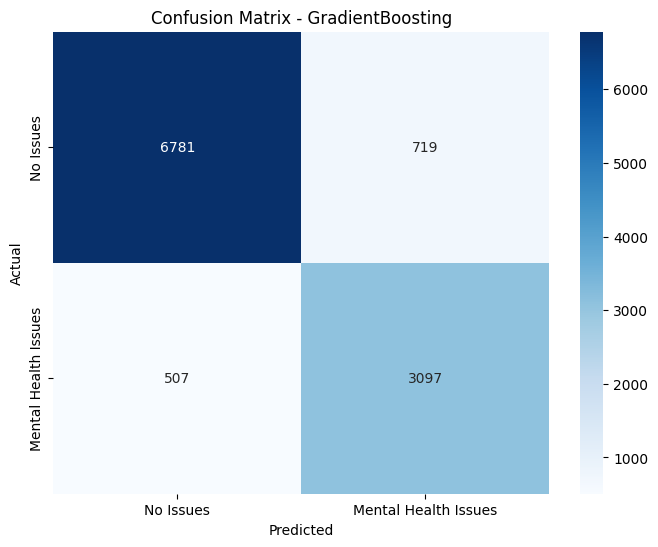

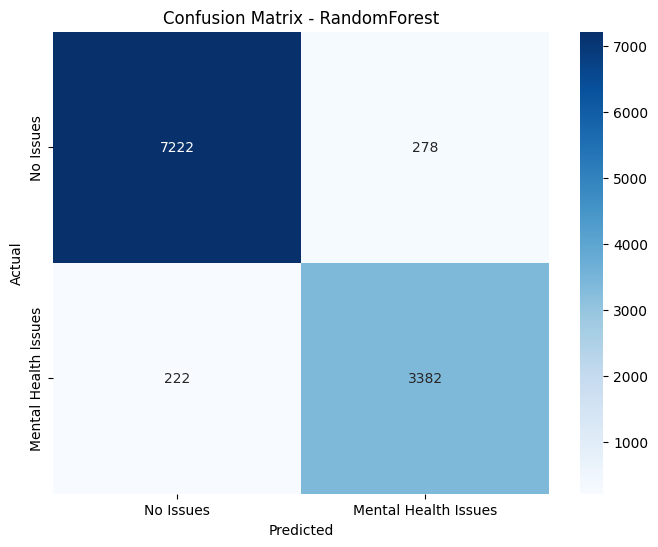

The best model is: RandomForest


TypeError: PermutationExplainer.shap_values() got an unexpected keyword argument 'check_additivity'

In [46]:
def main():
    file_path = 'Final_Cleaned.csv'
    data = load_data(file_path)

    if data is None:
        return

    # The prepare_data function returns X, y, and cv (TfidfVectorizer output)
    # It does *not* perform dimensionality reduction here.
    X, y, cv = prepare_data(data)

    if X is None or y is None:
        print("Error: X or y is None. Cannot proceed with training.")
        return

    models = {
        "MultinomialNB": MultinomialNB(),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "GradientBoosting": GradientBoostingClassifier(),
        "RandomForest": RandomForestClassifier(),

    }

    results = {}
    model_names = []

    # Use X (TF-IDF vectorized data) for training and evaluation
    for model_name, model_instance in models.items():
        results[model_name] = evaluate_models(X, y, model_instance, model_name)
        model_names.append(model_name)

    plot_combined_comparison_graph(results)  # Plot combined comparison graph
    plot_combined_roc_curves(results, model_names)  # Ensure ROC curves are combined

    # Separate confusion matrices
    for model_name in model_names:
        plot_confusion_matrix(results[model_name]['conf_matrix'], model_name)


    best_model_name = max(results, key=lambda name: results[name]['accuracy'])
    best_model = results[best_model_name]['model']

    print(f"The best model is: {best_model_name}")

    # Pass the original X, y, and cv to explain_models for SHAP analysis
    # explain_models handles dimensionality reduction internally if needed for SHAP
    explain_models({best_model_name: results[best_model_name]}, X, y, cv)


    print("Welcome to the Mental Health Detection System!")
    while True:
        text = input("Please enter a sentence (or type 'exit' to quit): ")
        if text.lower() == 'exit':
            break
        if not text.strip():
            print("Input cannot be empty. Please try again.")
            continue
        # Predict using the best model
        # Vectorize the input text using the same cv used for training
        processed_text = preprocess_text(text)
        text_vector = cv.transform([processed_text])

        # Note: If the best model is one that was trained on dimension-reduced data (like if you added SVD to the training pipeline),
        # you would need to apply the same SVD transformation here before prediction.
        # However, based on the current setup where training happens on X (TF-IDF output),
        # no further SVD transformation is needed for prediction using best_model.predict.
        prediction = best_model.predict(text_vector)
        print(f"Prediction: {prediction[0]}")


if __name__ == "__main__":
    main()